# Black-Box Neural Network

### Initialisation

In [1]:
import os
import pandas as pd

import numpy as np
import torch
import matplotlib.pyplot as plt
from nnodely import *
from nnodely.support.earlystopping import select_best_model
from pathlib import Path

# Models folder
path_folder = "trained_models"

# telemetries folder
path_train = "telemetries/training"
path_val   = "telemetries/validation"
path_test  = "telemetries/test"

# Import parameters:
vehicle_data = pd.read_csv("parameters/params.csv")
data_stats   = pd.read_csv("parameters/data_info.csv")
data_stats   = data_stats.iloc[0]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>-- nnodely_v1.5.2 --<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


### Model Structured Neural Network

In [2]:
# NNodely instantiation
lateral_model = nnodely(visualizer=MPLNotebookVisualizer(),seed=1,workspace=path_folder,save_history=False)

# ------------------------------------------- #
###  BLACK-BOX NEURAL NETWORK MODEL  ###
# ------------------------------------------- #

# -----------------------------------------
# Inputs
# -----------------------------------------
yaw_rate  = Input('yawRate')         # [rad/s] yaw rate
yaw_angle = Input('yawAngle')        # [rad] yaw angle
vx        = Input('vxCG')            # [m/s] longitudinal velocity
steer     = Input('handwheelAngle')  # [rad] steering wheel angle
ax        = Input('axCG')            # [m/s^2] longitudinal acceleration

# -----------------------------------------
# Hyperparameters
# -----------------------------------------
past_window = 10   # past samples 0.5s
act_func   = 'Tanh'  # activation function ['Relu', 'Tanh', 'Sigmoid']: applied to all hidden layers
H = [10,20,1]   # n° of neurons per layer

# -------------------------------------------
# Parametric Function: concatenate inputs
# -------------------------------------------
def concat(in1,in2,in3):
    return torch.cat((in1,in2,in3),2)

# -----------------------------------------
# Deep NN
# -----------------------------------------
vx_dyn = Fir(W='Fir_vx',W_init='init_negexp')(vx.sw(past_window))
ax_dyn = Fir(W='Fir_ax',W_init='init_negexp')(ax.sw(past_window))
steer_dyn = Fir(W='Fir_steer',W_init='init_negexp')(steer.sw(past_window))

nn_in = ParamFun(concat)(vx_dyn,ax_dyn,steer_dyn)

layers = []
layers.append(nn_in)

for i,k in enumerate(H):
    if i < len(H)-1:
        if act_func == 'Relu':
            layers.append(Relu(Linear(W=f"Linear{i}",b=True,output_dimension=k)(layers[i])))
        elif act_func == 'Tanh':
            layers.append(Tanh(Linear(W=f"Linear{i}",b=True,output_dimension=k)(layers[i])))
        elif act_func == 'Sigmoid':
            layers.append(Sigmoid(Linear(W=f"Linear{i}",b=True,output_dimension=k)(layers[i])))
    else:
        layers.append(Linear(W=f"Linear{i}",b=True,output_dimension=k)(layers[i]))

nn_out = layers[len(H)]

# -----------------------------------------
# Outputs
# -----------------------------------------
yaw_rate_out = Output('yaw_rate',nn_out)                                                               # yaw rate [deg/s]    
yaw_out      = Output('yaw_angle',Integrate(nn_out,int_name='yawAngle_int',
                                            der_name='yawRate_int',method='trapezoidal'))              # yaw angle [deg]

# -----------------------------------------
# Minimization and neuralization
# -----------------------------------------
lateral_model.addModel('lateral_model',[yaw_rate_out,yaw_out])

lateral_model.addMinimize('yaw_rate_error',
                    yaw_rate.next(),
                    yaw_rate_out,
                    loss_function='mse')

lateral_model.addMinimize('yaw_angle_error',
                    yaw_angle.next(),
                    yaw_out,
                    loss_function='mse')

lateral_model.neuralizeModel(sample_time=0.05)

[neuralizeModel] Closed loop on yawAngle_int with sample in the future.


[neuralizeModel] Connect on yawRate_int with sample in the future.


================================ nnodely Model =================================
{'Constants': {'Constant25': {'dim': 1, 'values': [0.5]},
               'SampleTime': {'dim': 1, 'values': 0.05}},
 'Functions': {'FParamFun12': {'code': 'def concat(in1,in2,in3):\n'
                                       '    return '
                                       'torch.cat((in1,in2,in3),2)\n',
                               'in_dim': [{'dim': 1, 'sw': 1},
                                          {'dim': 1, 'sw': 1},
                                          {'dim': 1, 'sw': 1}],
                               'map_over_dim': False,
                               'n_input': 3,
                               'name': 'concat',
                               'params_and_consts': []}},
 'Info': {'SampleTime': 0.05,
          'nnodely_version': '1.5.2',
          'ns': [10, 1],
          'ntot': 11,
          'num_parameters': 311},
 'Inputs': {'axCG': {'dim': 1, 'ns': [10, 0], 'ntot': 10, 'sw': [-

# Training

============================ nnodely Model Dataset =============================
Dataset Name:                 training_telem
Number of files:              2
Total number of samples:      10352
Shape of yawAngle_int:        (10352, 1, 1)
Shape of handwheelAngle:      (10352, 10, 1)
Shape of axCG:                (10352, 10, 1)
Shape of vxCG:                (10352, 10, 1)
Shape of yawRate_int:         (10352, 2, 1)
Shape of yawAngle:            (10352, 1, 1)
Shape of yawRate:             (10352, 1, 1)
============================ nnodely Model Dataset =============================
Dataset Name:                 valid_telem
Number of files:              1
Total number of samples:      7748
Shape of yawAngle_int:        (7748, 1, 1)
Shape of handwheelAngle:      (7748, 10, 1)
Shape of axCG:                (7748, 10, 1)
Shape of vxCG:                (7748, 10, 1)
Shape of yawRate_int:         (7748, 2, 1)
Shape of yawAngle:            (7748, 1, 1)
Shape of yawRate:             (7748, 1, 1)


======================== nnodely Model Train Parameters ========================
models:                       ['lateral_model']
num of epochs:                100
update per epochs:            36
└>len(train_indexes)//(batch_size+step)
shuffle data:                 True
prediction samples:           500
step:                         0
closed loop:                  {}
connect:                      {}
train dataset:                training_telem
	- batch size:                256
	- num of samples:            10352
	- num of first samples:      9352
validation dataset:           valid_telem
	- batch size:                256
	- num of samples:            7748
	- num of first samples:      7248
minimizers:                   {'yaw_angle_error': {'A': 'SamplePart31',
                                                   'B': 'Add26',
                                                   'gain': 0.1,
                                                   'loss': 'mse'},
                               'y

|  1/100   |5.838e+01|2.348e+01|2.725e+02|4.693e+01|1.654e+02|3.521e+01|


|  2/100   |1.288e+01|8.385e+00|2.072e+01|1.137e+01|1.680e+01|9.877e+00|


|  3/100   |7.447e+00|7.664e+00|8.456e+00|1.055e+01|7.951e+00|9.108e+00|


|  4/100   |6.884e+00|7.447e+00|7.096e+00|1.033e+01|6.990e+00|8.891e+00|


|  5/100   |6.476e+00|6.765e+00|6.534e+00|9.302e+00|6.505e+00|8.034e+00|


|  6/100   |6.024e+00|6.472e+00|6.262e+00|9.178e+00|6.143e+00|7.825e+00|


|  7/100   |5.711e+00|6.066e+00|6.021e+00|8.565e+00|5.866e+00|7.315e+00|


|  8/100   |5.341e+00|6.029e+00|5.837e+00|9.675e+00|5.589e+00|7.852e+00|


|  9/100   |5.070e+00|5.401e+00|5.428e+00|7.126e+00|5.249e+00|6.264e+00|


|  10/100  |4.784e+00|5.257e+00|4.964e+00|7.512e+00|4.874e+00|6.385e+00|


|  11/100  |4.815e+00|5.248e+00|5.212e+00|7.152e+00|5.014e+00|6.200e+00|


|  12/100  |4.630e+00|4.886e+00|5.028e+00|7.201e+00|4.829e+00|6.044e+00|


|  13/100  |4.552e+00|4.879e+00|5.031e+00|7.115e+00|4.792e+00|5.997e+00|


|  14/100  |4.467e+00| 4.8e+00 |5.058e+00|6.408e+00|4.762e+00|5.604e+00|


|  15/100  |4.381e+00|5.069e+00|5.184e+00|8.093e+00|4.782e+00|6.581e+00|


|  16/100  |4.379e+00|4.678e+00|5.087e+00|5.806e+00|4.733e+00|5.242e+00|


|  17/100  |4.339e+00| 5.05e+00|5.283e+00|7.341e+00|4.811e+00|6.196e+00|


|  18/100  |4.278e+00|4.787e+00|5.051e+00|6.939e+00|4.665e+00|5.863e+00|


|  19/100  |4.262e+00|5.025e+00|5.712e+00|1.005e+01|4.987e+00|7.535e+00|


|  20/100  |4.427e+00| 4.56e+00|5.843e+00|5.802e+00|5.135e+00|5.181e+00|


|  21/100  |4.221e+00|4.638e+00|4.892e+00|6.143e+00|4.557e+00|5.391e+00|


|  22/100  |4.144e+00|4.427e+00|5.049e+00|6.021e+00|4.597e+00|5.224e+00|


|  23/100  |4.198e+00|4.615e+00|4.788e+00|6.338e+00|4.493e+00|5.477e+00|


|  24/100  |4.147e+00|4.580e+00|5.025e+00| 5.06e+00|4.586e+00| 4.82e+00|


|  25/100  |4.345e+00|4.671e+00| 5.36e+00|5.846e+00|4.853e+00|5.258e+00|


|  26/100  |4.214e+00|4.642e+00|4.895e+00|6.483e+00|4.555e+00|5.562e+00|


|  27/100  |4.132e+00|4.600e+00|5.075e+00|6.124e+00|4.604e+00|5.362e+00|


|  28/100  |4.076e+00|4.544e+00|4.856e+00|6.736e+00|4.466e+00|5.640e+00|


|  29/100  |4.183e+00|5.029e+00|4.978e+00|8.197e+00|4.581e+00|6.613e+00|


|  30/100  |4.469e+00|4.751e+00|5.823e+00|5.616e+00|5.146e+00|5.183e+00|


|  31/100  | 4.42e+00|4.791e+00|4.926e+00|4.026e+00|4.673e+00|4.409e+00|


|  32/100  |4.407e+00|4.784e+00|5.587e+00|7.314e+00|4.997e+00|6.049e+00|


|  33/100  |4.266e+00|4.296e+00|5.752e+00|4.248e+00|5.009e+00|4.272e+00|


|  34/100  |4.139e+00|4.601e+00|4.961e+00|6.768e+00| 4.55e+00|5.685e+00|


|  35/100  |4.209e+00|4.698e+00|5.141e+00|5.550e+00|4.675e+00|5.124e+00|


|  36/100  |4.324e+00|4.687e+00|5.420e+00|5.178e+00|4.872e+00|4.933e+00|


|  37/100  |4.216e+00|4.785e+00|5.095e+00|6.343e+00|4.655e+00|5.564e+00|


|  38/100  |4.426e+00|4.811e+00|6.089e+00|6.774e+00|5.257e+00|5.793e+00|


|  39/100  |4.369e+00|4.591e+00|5.614e+00|5.723e+00|4.992e+00|5.157e+00|


|  40/100  |4.328e+00|4.690e+00|5.567e+00|6.572e+00|4.948e+00|5.631e+00|


|  41/100  |4.595e+00|5.013e+00|6.723e+00|7.765e+00|5.659e+00|6.389e+00|


|  42/100  |4.420e+00|4.859e+00|6.123e+00|6.357e+00|5.272e+00|5.608e+00|


|  43/100  |4.410e+00|5.472e+00|5.585e+00|8.116e+00|4.997e+00|6.794e+00|


|  44/100  |4.451e+00|4.641e+00|5.268e+00|4.955e+00|4.859e+00|4.798e+00|


|  45/100  |4.493e+00|4.804e+00| 6.15e+00|7.658e+00|5.321e+00|6.231e+00|


|  46/100  | 4.25e+00|4.563e+00|5.636e+00|5.347e+00|4.943e+00|4.955e+00|


|  47/100  |4.358e+00|4.563e+00|5.623e+00|7.119e+00|4.990e+00|5.841e+00|


|  48/100  |4.183e+00|4.488e+00|5.521e+00|7.073e+00|4.852e+00|5.781e+00|


|  49/100  |4.512e+00|5.142e+00|6.051e+00|6.702e+00|5.281e+00|5.922e+00|


|  50/100  |4.613e+00|4.835e+00|7.386e+00|7.172e+00|  6.e+00 |6.004e+00|


|  51/100  |4.469e+00|5.022e+00|6.509e+00|8.155e+00|5.489e+00|6.589e+00|


|  52/100  |4.482e+00|4.789e+00|6.717e+00|6.313e+00|5.599e+00|5.551e+00|


|  53/100  |4.233e+00|4.472e+00|5.951e+00|6.178e+00|5.092e+00|5.325e+00|


|  54/100  |4.153e+00| 4.17e+00|5.914e+00|4.767e+00|5.034e+00|4.468e+00|


|  55/100  |4.097e+00|5.533e+00|5.849e+00|1.111e+01|4.973e+00|8.321e+00|


|  56/100  |4.455e+00|5.885e+00|7.033e+00|1.177e+01|5.744e+00|8.828e+00|


|  57/100  |4.148e+00|4.827e+00|5.721e+00| 1.04e+01|4.934e+00|7.612e+00|


|  58/100  |4.168e+00|4.880e+00|7.038e+00|6.736e+00|5.603e+00|5.808e+00|


|  59/100  |4.229e+00|4.737e+00|6.012e+00|5.402e+00|5.120e+00| 5.07e+00|


|  60/100  |4.183e+00|4.397e+00|5.762e+00|6.599e+00|4.972e+00|5.498e+00|


|  61/100  |4.051e+00|4.120e+00|6.101e+00|4.671e+00|5.076e+00|4.395e+00|


|  62/100  |4.228e+00|4.923e+00|6.559e+00|7.687e+00|5.393e+00|6.305e+00|


|  63/100  |3.988e+00|4.460e+00|5.719e+00|8.690e+00|4.854e+00|6.575e+00|


|  64/100  |4.129e+00|4.874e+00|5.977e+00|6.244e+00|5.053e+00|5.559e+00|


|  65/100  |4.066e+00|4.381e+00|6.094e+00|7.223e+00| 5.08e+00|5.802e+00|


|  66/100  |4.526e+00|4.321e+00|6.318e+00|6.833e+00|5.422e+00|5.577e+00|


|  67/100  |4.087e+00|4.266e+00|6.514e+00|6.320e+00|5.300e+00|5.293e+00|


|  68/100  |4.078e+00|4.622e+00|6.162e+00|5.631e+00|5.120e+00|5.126e+00|


|  69/100  |4.008e+00|4.996e+00|5.667e+00|8.646e+00|4.837e+00|6.821e+00|


|  70/100  |4.419e+00|5.034e+00| 5.7e+00 |8.314e+00|5.059e+00|6.674e+00|


|  71/100  |4.191e+00|4.369e+00|6.632e+00|6.341e+00|5.412e+00|5.355e+00|


|  72/100  |4.103e+00|4.291e+00|6.195e+00|5.083e+00|5.149e+00|4.687e+00|


|  73/100  |4.121e+00|4.606e+00|5.823e+00|4.634e+00|4.972e+00|4.620e+00|


|  74/100  |4.228e+00|4.167e+00|5.516e+00|6.525e+00|4.872e+00|5.346e+00|


|  75/100  |4.354e+00|4.833e+00|8.036e+00|7.907e+00|6.195e+00| 6.37e+00|


|  76/100  |4.594e+00|5.177e+00|7.052e+00|7.945e+00|5.823e+00|6.561e+00|


|  77/100  |4.533e+00|4.511e+00|7.355e+00|5.511e+00|5.944e+00|5.011e+00|


|  78/100  |4.281e+00|5.061e+00|7.989e+00|7.286e+00|6.135e+00|6.174e+00|


|  79/100  |4.624e+00|4.861e+00|7.920e+00|7.330e+00|6.272e+00|6.095e+00|


|  80/100  | 4.21e+00|5.016e+00|6.127e+00|9.144e+00|5.168e+00|7.080e+00|


|  81/100  |4.470e+00| 4.71e+00|5.731e+00|5.981e+00|5.101e+00|5.345e+00|


|  82/100  |4.641e+00|4.540e+00|6.182e+00|5.990e+00|5.411e+00|5.265e+00|


|  83/100  |4.347e+00|5.023e+00|6.134e+00|8.198e+00|5.241e+00|6.610e+00|


|  84/100  |4.694e+00|5.512e+00|6.379e+00|6.176e+00|5.537e+00|5.844e+00|


|  85/100  |5.091e+00|5.162e+00|5.810e+00|5.718e+00|5.451e+00| 5.44e+00|


|  86/100  |5.094e+00|5.608e+00|6.586e+00|8.221e+00|5.840e+00|6.914e+00|


|  87/100  |5.214e+00|6.126e+00|6.234e+00|1.148e+01|5.724e+00|8.800e+00|


|  88/100  |5.542e+00|5.928e+00|6.537e+00|5.641e+00|6.039e+00|5.785e+00|


|  89/100  |5.364e+00|5.764e+00|5.797e+00|6.993e+00|5.580e+00|6.378e+00|


|  90/100  |5.382e+00|6.735e+00|5.741e+00|1.750e+01|5.562e+00|1.212e+01|


|  91/100  |5.867e+00|6.217e+00|8.297e+00|6.793e+00|7.082e+00|6.505e+00|


|  92/100  |5.505e+00|5.768e+00|5.962e+00|4.395e+00|5.734e+00|5.082e+00|


|  93/100  | 5.87e+00|6.103e+00|5.796e+00|8.995e+00|5.833e+00|7.549e+00|


|  94/100  |5.023e+00|5.452e+00|6.515e+00|9.127e+00|5.769e+00|7.289e+00|


|  95/100  |4.711e+00|5.298e+00|6.764e+00|7.222e+00|5.737e+00|6.260e+00|


|  96/100  |4.566e+00|5.194e+00|5.500e+00|1.030e+01|5.033e+00|7.749e+00|


|  97/100  |4.799e+00|5.921e+00|6.197e+00|8.513e+00|5.498e+00|7.217e+00|


|  98/100  |5.002e+00|5.648e+00|6.268e+00|6.306e+00|5.635e+00|5.977e+00|


|  99/100  |4.965e+00|5.424e+00|7.284e+00|8.164e+00|6.124e+00|6.794e+00|


| 100/100  |4.956e+00|6.092e+00|6.439e+00|9.036e+00|5.698e+00|7.564e+00|
|----------------------------------------------------------------------|
============================ nnodely Training Time =============================
Total time of Training:       4457.5131459236145


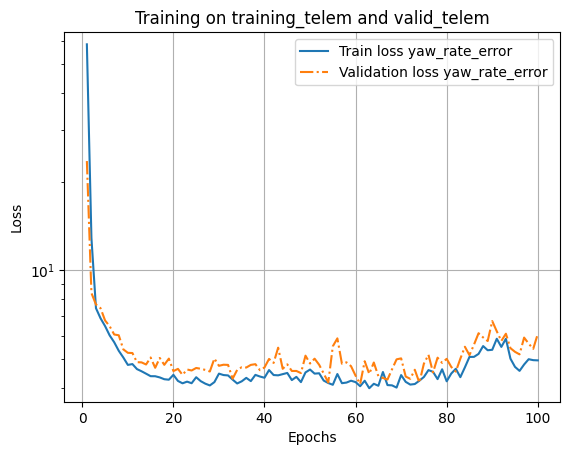

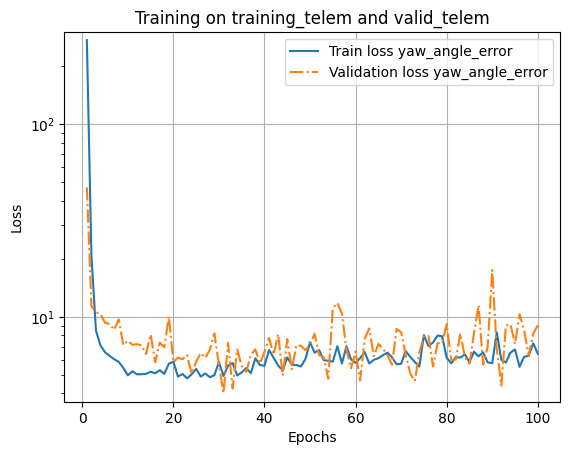

Selected the model at the epoch 33.


======================== nnodely Model Train Parameters ========================
models:                       ['lateral_model']
num of epochs:                20
update per epochs:            36
└>len(train_indexes)//(batch_size+step)
shuffle data:                 True
prediction samples:           500
step:                         0
closed loop:                  {}
connect:                      {}
train dataset:                training_telem
	- batch size:                256
	- num of samples:            10352
	- num of first samples:      9352
validation dataset:           valid_telem
	- batch size:                256
	- num of samples:            7748
	- num of first samples:      7248
minimizers:                   {'yaw_angle_error': {'A': 'SamplePart31',
                                                   'B': 'Add26',
                                                   'gain': 0.1,
                                                   'loss': 'mse'},
                               'ya

|   1/20   |4.046e+00|4.371e+00| 4.77e+00|5.142e+00|4.408e+00|4.757e+00|


|   2/20   |3.948e+00|4.377e+00|4.416e+00| 5.25e+00|4.182e+00|4.813e+00|


|   3/20   |3.918e+00|4.386e+00|4.278e+00|5.379e+00|4.098e+00|4.883e+00|


|   4/20   |3.904e+00|4.390e+00|4.235e+00|5.282e+00| 4.07e+00|4.836e+00|


|   5/20   |3.899e+00|4.429e+00|4.179e+00|5.319e+00|4.039e+00|4.874e+00|


|   6/20   |3.897e+00|4.439e+00|4.145e+00|5.255e+00|4.021e+00|4.847e+00|


|   7/20   |3.915e+00|4.460e+00|4.119e+00|5.229e+00|4.017e+00|4.845e+00|


|   8/20   |3.916e+00|4.477e+00|4.072e+00|5.212e+00|3.994e+00|4.844e+00|


|   9/20   |3.920e+00|4.466e+00|4.032e+00|5.242e+00|3.976e+00|4.854e+00|


|  10/20   |3.933e+00|4.468e+00|4.035e+00|5.205e+00|3.984e+00|4.836e+00|


|  11/20   |3.933e+00|4.468e+00|4.021e+00|5.194e+00|3.977e+00|4.831e+00|


|  12/20   |3.928e+00|4.452e+00|4.013e+00|5.105e+00|3.971e+00|4.778e+00|


|  13/20   |3.930e+00|4.467e+00|4.012e+00|5.266e+00|3.971e+00|4.867e+00|


|  14/20   |3.920e+00| 4.45e+00|3.995e+00|5.189e+00|3.958e+00|4.819e+00|


|  15/20   | 3.92e+00|4.455e+00|3.993e+00|5.247e+00|3.956e+00|4.851e+00|


|  16/20   |3.909e+00|4.469e+00|3.994e+00|5.388e+00|3.952e+00|4.929e+00|


|  17/20   |3.908e+00|4.448e+00|3.999e+00|5.214e+00|3.953e+00|4.831e+00|


|  18/20   |3.911e+00|4.463e+00|3.982e+00|5.430e+00|3.947e+00|4.947e+00|


|  19/20   |3.904e+00|4.444e+00|4.001e+00| 5.23e+00|3.953e+00|4.837e+00|


|  20/20   |3.909e+00|4.453e+00|3.988e+00|5.283e+00|3.949e+00|4.868e+00|
|----------------------------------------------------------------------|
============================ nnodely Training Time =============================
Total time of Training:       769.437493801117


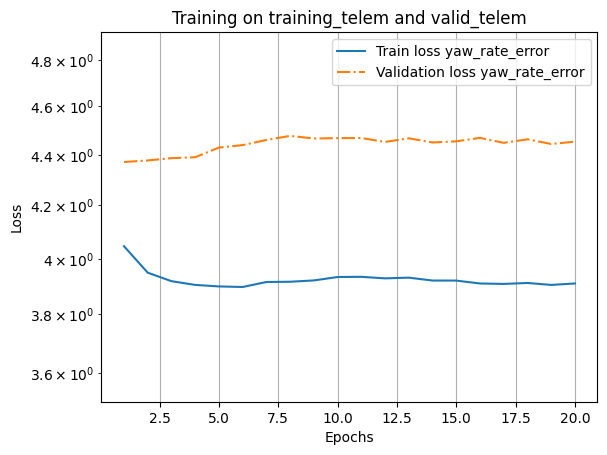

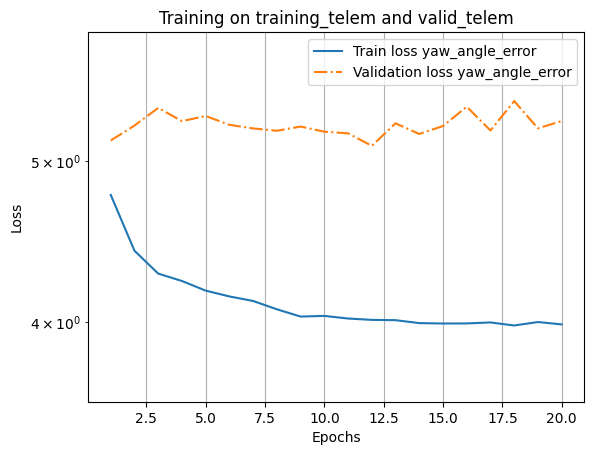

Selected the model at the epoch 1.


=============================== Save JSON Model ================================
Model saved in:               trained_models/BB_NN.json


In [3]:
# -----------------------------------------
# Load Datasets
# -----------------------------------------
lateral_model.loadData(name='training_telem',source=path_train,format=['','handwheelAngle','vxCG','axCG','ayCG',('yawAngle','yawAngle_int'),('yawRate','yawRate_int')],skiplines=1)
lateral_model.loadData(name='valid_telem',   source=path_val,  format=['','handwheelAngle','vxCG','axCG','ayCG',('yawAngle','yawAngle_int'),('yawRate','yawRate_int')],skiplines=1)

# -----------------------------------------
# Training
# -----------------------------------------
num_epochs = 20
batch_size = 256
learn_rate = 1e-3
early_stop_patience = 5 
n_prediction = 500   # 25s of prediction
training_pars = {'train_dataset':'training_telem',
                 'validation_dataset':'valid_telem',
                 'num_of_epochs':num_epochs, 
                 'val_batch_size':batch_size, 
                 'train_batch_size':batch_size, 
                 'lr':learn_rate,
                 'shuffle_data':True,
                 'optimizer':'Adam',
                 'select_model':select_best_model,
                 'prediction_samples':n_prediction,   # force to avoid prediction: intergal evaluated only during inference
                 'minimize_gain':{'yaw_rate_error':1.0, 'yaw_angle_error':0.1},
                 'early_stopping_params':{'patience':early_stop_patience,'error':'yaw_rate_error', 'threshold':0.05}}

# First training
lateral_model.trainModel(training_params=training_pars,lr=1e-1,num_of_epochs=100)
# Refining
lateral_model.trainModel(training_params=training_pars)

# -----------------------------------------
# Save json model
# -----------------------------------------
lateral_model.saveModel('BB_NN')

# Analyse results

=============================== Load JSON Model ================================
Model loaded from:            trained_models/BB_NN.json
[neuralizeModel] Closed loop on yawAngle_int with sample in the future.


[neuralizeModel] Connect on yawRate_int with sample in the future.


================================ nnodely Model =================================
{'Constants': {'Constant25': {'dim': 1, 'values': [0.5]},
               'SampleTime': {'dim': 1, 'values': 0.05}},
 'Functions': {'FParamFun12': {'code': 'def concat(in1,in2,in3):\n'
                                       '    return '
                                       'torch.cat((in1,in2,in3),2)\n',
                               'in_dim': [{'dim': 1, 'sw': 1},
                                          {'dim': 1, 'sw': 1},
                                          {'dim': 1, 'sw': 1}],
                               'map_over_dim': False,
                               'n_input': 3,
                               'name': 'concat',
                               'params_and_consts': []}},
 'Info': {'SampleTime': 0.05,
          'nnodely_version': '1.5.2',
          'ns': [10, 1],
          'ntot': 11,
          'num_parameters': 311},
 'Inputs': {'axCG': {'dim': 1, 'ns': [10, 0], 'ntot': 10, 'sw': [-

==================== nnodely Model Results for test_telem ===================
|      Loss     |        mse        |        FVU        |        AIC        |
|               |    small better   |    small better   |    lower better   |
|---------------------------------------------------------------------------|
|yaw_angle_error|     5.560e+01     |     3.408e-04     |     3.851e+06     |
| yaw_rate_error|     4.293e+00     |     2.254e-02     |      3.82e+06     |
|---------------------------------------------------------------------------|
|     Total     |     2.995e+01     |     1.144e-02     |     3.835e+06     |
|---------------------------------------------------------------------------|


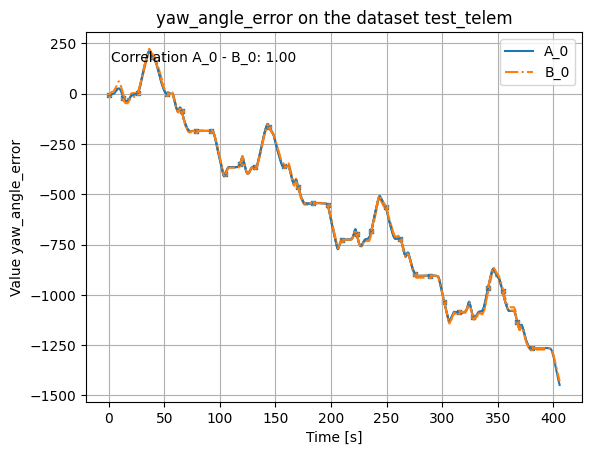

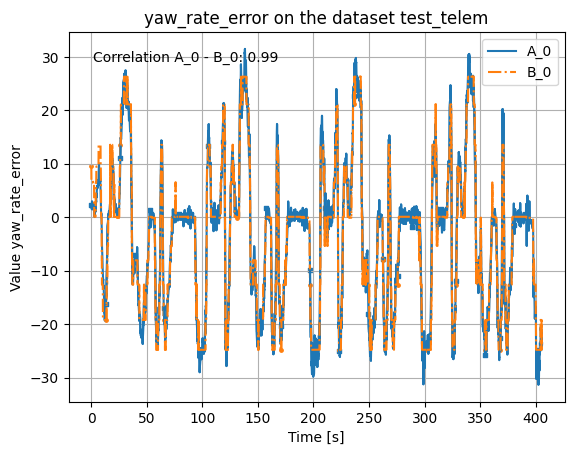

In [4]:

# -----------------------------------------
# Load model and data
# -----------------------------------------    
lateral_model.loadModel('BB_NN')
lateral_model.neuralizeModel()
lateral_model.loadData(name='test_telem',   source=path_test,  format=['','handwheelAngle','vxCG','axCG','ayCG',('yawAngle','yawAngle_int'),('yawRate','yawRate_int')],skiplines=1)

n_prediction = 500   # 25s of prediction

# -----------------------------------------
# Analyse model
# ----------------------------------------- 
lateral_model.analyzeModel('test_telem' ,prediction_samples=n_prediction)

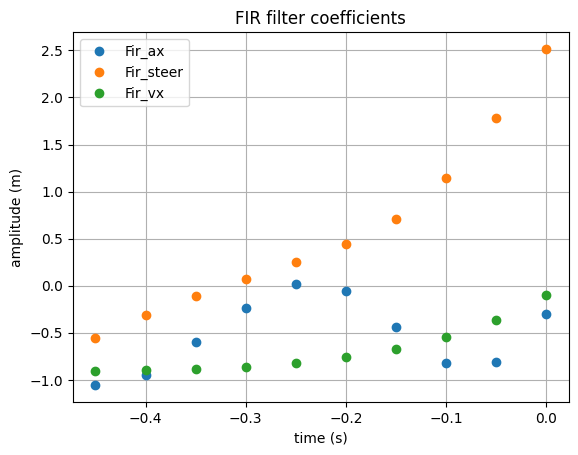

In [5]:
# -----------------------------------------
# Fir filter plot
# ----------------------------------------- 
params_fir = {}
sampling_time = 0.05
idx = 0

# Extract the weights
plt.figure()
for key, value in lateral_model.parameters.items():
    if key.startswith('Fir_'):
        params_fir[key] = lateral_model.parameters[key]
for key, value in params_fir.items():
    vals = np.array(value).flatten()
    t = np.linspace(-sampling_time * (len(vals)-1), 0, len(vals))
    plt.plot(t,vals, 'o', label=key)
    idx += 1
plt.title('FIR filter coefficients')
plt.xlabel('time (s)')
plt.ylabel('amplitude (m)')
plt.legend()
plt.grid(True)

In [6]:
# -----------------------------------------
# NN inference
# ----------------------------------------- 
prediction = 500   # intergal over 25s
window     = 2000
data_sampled = lateral_model.getSamples('test_telem', window=window)

NN_out = lateral_model(inputs=data_sampled,sampled=True,prediction_samples=prediction)
time = 0.05 * np.arange(window)

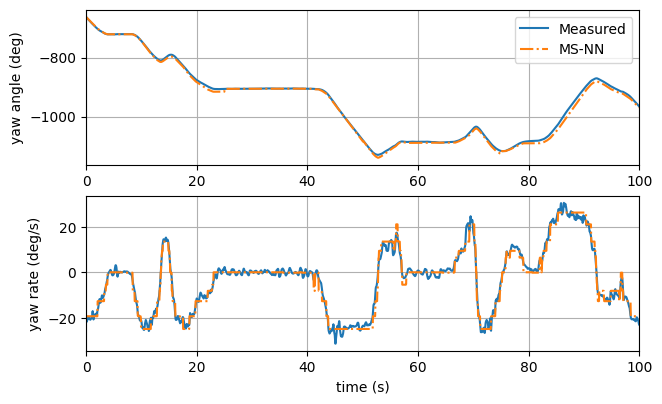

In [7]:
# Yaw prediction plot
width = 7.14         # inches for IEEE column
aspect_ratio = 0.62  # height/width ratio

fig, ax = plt.subplots(2,1,figsize=(width, width * aspect_ratio))

ax[0].plot(time,np.array(data_sampled['yawAngle']).squeeze(), label='Measured')
ax[0].plot(time,NN_out['yaw_angle'], '-.', label='MS-NN')  
ax[0].set_xlim(0,100)
ax[0].set_ylabel('yaw angle (deg)')
ax[0].legend()
ax[0].grid()

# Yaw rate prediction plot
ax[1].plot(time,np.array(data_sampled['yawRate']).squeeze(), label='measured')
ax[1].plot(time,NN_out['yaw_rate'], '-.', label='NN output')  
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('yaw rate (deg/s)')
ax[1].grid()
ax[1].sharex(ax[0])